based on https://hsf-training.github.io/hsf-training-scikit-hep-webpage/

## **Introduction**

We will study basic tools and wrappers for enabling not-too-alien syntax when running columnar collider HEP analysis. This tools are part of a pythonic HEP ecosystem. 

![](https://i.imgur.com/3a11SeT.png)

To make things easier to find, they're cataloged under a common name at [scikit-hep.org](https://scikit-hep.org/)

## **ROOT file structure and terminology**

A ROOT file is like a little filesystem containing nested directories. Any class instance (like `ROOT TObject`) can be stored in a directory.

One of these classes, TTree, is a gateway to large datasets. A TTree is roughly like a Pandas DataFrame in that it represents a table of data. The columns are called TBranches, which can be nested (unlike Pandas), and the data can have any C++ type (unlike Pandas, which can store any Python type).

A TTree is often too large to fit in memory, and sometimes (rarely) even a single TBranch is too large to fit in memory. Each TBranch is therefore broken down into TBaskets, which are “batches” of data. TBaskets are the smallest unit that can be read from a TTree: if you want to read the first entry, you have to read the first TBasket.

As a data analyst, you’ll likely be concerned with TTrees and TBranches first-hand, but only TBaskets when efficiency issues come up

![](https://i.imgur.com/gkN0q9f.png)

CMS data has this structure and can be found in different formats. One of these formats is the so-called **NanoAOD** format. A NanoAOD file contains a main TTree named **Events**. A dump of the documentation of content for different releases is available [here](https://cms-nanoaod-integration.web.cern.ch/autoDoc/)

## **Reading and manipulating data**

[Uproot](https://uproot.readthedocs.io/en/latest/) is a Python package that reads and writes ROOT files and is only concerned with reading and writing (no analysis, no plotting, etc.). It interacts with NumPy, Awkward Array, and Pandas for computations, boost-histogram/hist for histogram manipulation and plotting, Vector for Lorentz vector functions and transformations, Coffea for scale-up, etc.

Uproot is implemented using only Python and Python libraries.

![](https://i.imgur.com/pt8y1c1.png)

To access a remote file via XRootD, we use a `root://...` URL:



In [1]:
# file name
fname = "root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"

We can use `uproot.open()` to open a ROOT file. Instead, we will use the `coffea.nanoevents.NanoEventsFactory()` (which uses `uproot.open` internally) to read the ROOT File and create a `NanoEvents` object (with a `NanoAODSchema`). To limit the amount of data read, set `entry_stop` to the range you want:

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Missing cross-reference index ")

In [3]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# load events
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema, entry_stop=10).events()

Browsing through the nanoAOD event content is useful to understand each branch. We can list its content using the `fields` attribute:

In [4]:
# events fields
events.fields

['HLT',
 'MET',
 'Electron',
 'run',
 'Photon',
 'PV',
 'Tau',
 'Muon',
 'Jet',
 'luminosityBlock',
 'event']

In [5]:
# jet fields
events.Jet.fields

['pt', 'eta', 'phi', 'mass', 'puId', 'btag']

In [6]:
# jet transverse momentum
events.Jet.pt

<Array [[71.7, 27.8], [23.2, ... [], [31.9]] type='10 * var * float32[parameters...'>

In [7]:
def print_ak_array(array):
    for i in array:
        print(i)
        
print_ak_array(events.Jet.pt)

[71.7, 27.8]
[23.2, 21.1, 17.4]
[72.6, 51.3, 33.7]
[18.9]
[]
[]
[20.1, 17.8]
[38.3]
[]
[31.9]


Arrays like these are sometimes called "jagged arrays". A jagged array is an irregular array, in other words, an array of arrays of which the member arrays can be of different lengths.

[Awkward](https://awkward-array.org/doc/main/index.html) is a library, part of the pythonic HEP ecosystem, used for manipulating these jagged arrays using NumPy-like idioms. Basically, it is a generalization of NumPy for irregular arrays.





In [8]:
import awkward as ak

**operations:** Arrays are dynamically typed, but operations on them are compiled and fast

In [9]:
# jet transverse momentum squared
events.Jet.pt ** 2

<Array [[5.15e+03, 774], ... [], [1.02e+03]] type='10 * var * float32'>

**slicing:** Basic slices are a generalization of NumPy's, what NumPy would do if it had variable-length lists (Boolean and integer slices work too)

In [10]:
# jet transverse momentum
jet_pt = events.Jet.pt

In [11]:
# first event
jet_pt[0]

<Array [71.7, 27.8] type='2 * float32[parameters={"__doc__": "Jet_pt[nJet]/F"}]'>

In [12]:
# second event
jet_pt[1]

<Array [23.2, 21.1, 17.4] type='3 * float32[parameters={"__doc__": "Jet_pt[nJet]...'>

In [13]:
# first element of the first two events
jet_pt[:2, 0]

<Array [71.7, 23.2] type='2 * float32[parameters={"__doc__": "Jet_pt[nJet]/F"}]'>

Note that if, for example, an event has no elements, this type of slicing will fail

In [14]:
# first element of all events
jet_pt[:, 0]

ValueError: in ListOffsetArray64 attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/cpu-kernels/awkward_NumpyArray_getitem_next_at.cpp#L21)

In such cases, we can use the Awkward `pad_none()` function to increase the lengths of lists to a target length by adding `None` values, so that we can perform the slicing:

In [15]:
# pad None's
pad_jet_pt = ak.pad_none(jet_pt, target=1)

In [16]:
print_ak_array(pad_jet_pt)

[71.7, 27.8]
[23.2, 21.1, 17.4]
[72.6, 51.3, 33.7]
[18.9]
[None]
[None]
[20.1, 17.8]
[38.3]
[None]
[31.9]


In [17]:
# first element of all events
print_ak_array(pad_jet_pt[:, 0])

71.74247741699219
23.159303665161133
72.6034164428711
18.851543426513672
None
None
20.137300491333008
38.28268051147461
None
31.946998596191406


**Application: selecting particles and events**

**particle-level cut**: This jagged array of booleans selects all muons with at least 20 GeV in transverse momentum

In [18]:
particle_cut = events.Muon.pt > 20

print_ak_array(particle_cut)

[False]
[True]
[True, False, False, False, False, False]
[True]
[True]
[True]
[True]
[False]
[True]
[True]


In [19]:
muons = events.Muon[particle_cut]

print_ak_array(muons)

[]
[Muon]
[Muon]
[Muon]
[Muon]
[Muon]
[Muon]
[]
[Muon]
[Muon]


**event-level cut**: This non-jagged array of booleans (made with `ak.any`) selects all events that have a muon with at least 20 GeV in transverse momentum:

In [20]:
event_cut  = ak.any(events.Muon.pt > 20, axis=1)

print_ak_array(event_cut)

False
True
True
True
True
True
True
False
True
True


In [21]:
muons = events.Muon[event_cut]

print_ak_array(muons)

[Muon]
[Muon, Muon, Muon, Muon, Muon, Muon]
[Muon]
[Muon]
[Muon]
[Muon]
[Muon]
[Muon]


## **Boost-histogram and Hist**

High-energy physicists usually want to fill histograms with more data than can fit in memory, which means setting bin intervals on an empty container and filling it in batches (sequentially or in parallel). Boost-histogram is a library designed for that purpose. 

A more user-friendly layer is provided by a library called [Hist](https://hist.readthedocs.io/en/latest/), which is a powerful histogramming tool within the python HEP ecosystem for analysis based on Boost-histogram. It provides:

* N-dimensional histograms
* Discrete and dense axis: Regular, Boolean, Variable, Integer, IntCategory and StrCategory.
* Useful methods to transform and index histograms
* Plotting via matplotlib or mplhep: stacked and normalized plots, ratio plots, 2D plots, etc.

**1-dimensional Histogram**

In [22]:
import hist

# definition of a regular axis
jet_pt_axis = hist.axis.Regular(
    bins=40, 
    start=20, 
    stop=1000, 
    name="jet_pt", 
    label="Jet $p_T$ [GeV]"
)

# 1D histogram
jet_pt_histogram = hist.Hist(jet_pt_axis)

jet_pt_histogram

Hist(Regular(40, 20, 1000, name='jet_pt', label='Jet $p_T$ [GeV]'), storage=Double())

In [23]:
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema, entry_stop=10_000).events()

jet_pt = events.Jet.pt[events.Jet.pt > 20]

Since this is a jagged array, it can't be directly histogrammed. Histograms take a set of numbers as inputs, but this array contains lists.

You can use `ak.flatten()` to flatten one level of list or `ak.ravel()` to flatten all levels

In [24]:
# filling the histogram
jet_pt_histogram.fill(jet_pt=ak.flatten(jet_pt))

jet_pt_histogram

Hist(Regular(40, 20, 1000, name='jet_pt', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 10723.0

we can plot the histogram using the `plot1d()` method

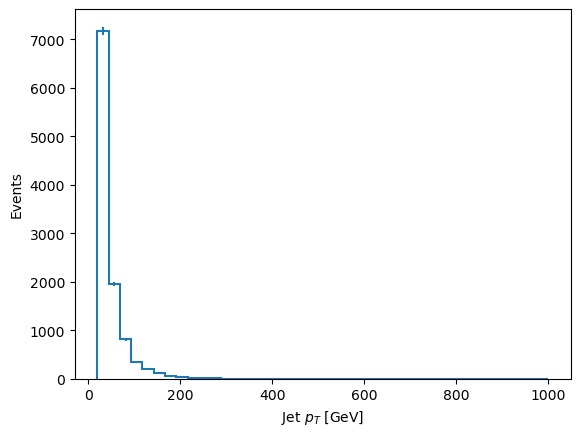

In [25]:
import matplotlib.pyplot as plt

jet_pt_histogram.plot1d()
plt.ylabel("Events");

**N-dimensional Histogram**

In [26]:
import numpy as np

# jet axes
jet_pt_axis = hist.axis.Variable(
    edges=[20, 60, 90, 120, 150, 180, 210, 240, 300, 500],
    name="jet_pt",
    label="Jet $p_T$ [GeV]"
)
jet_eta_axis = hist.axis.Regular(
    bins=50,
    start=-2.4,
    stop=2.4,
    name="jet_eta",
    label="jet $\eta$"
)
jet_phi_axis = hist.axis.Regular(
    bins=50,
    start=-np.pi,
    stop=np.pi,
    name="jet_phi",
    label="Jet $\phi$"
)

# 3D histogram
jet_histogram = hist.Hist(
    jet_pt_axis,
    jet_eta_axis,
    jet_phi_axis,
)
jet_histogram

Hist(
  Variable([20, 60, 90, 120, 150, 180, 210, 240, 300, 500], name='jet_pt', label='Jet $p_T$ [GeV]'),
  Regular(50, -2.4, 2.4, name='jet_eta', label='jet $\\eta$'),
  Regular(50, -3.14159, 3.14159, name='jet_phi', label='Jet $\\phi$'),
  storage=Double())

In [27]:
# filling the histogram
jet_histogram.fill(
    jet_pt=ak.flatten(events.Jet.pt),
    jet_eta=ak.flatten(events.Jet.eta),
    jet_phi=ak.flatten(events.Jet.phi)
)
jet_histogram

Hist(
  Variable([20, 60, 90, 120, 150, 180, 210, 240, 300, 500], name='jet_pt', label='Jet $p_T$ [GeV]'),
  Regular(50, -2.4, 2.4, name='jet_eta', label='jet $\\eta$'),
  Regular(50, -3.14159, 3.14159, name='jet_phi', label='Jet $\\phi$'),
  storage=Double()) # Sum: 8652.0 (16840.0 with flow)

We can inspect an individual axis, using the `project()` method first

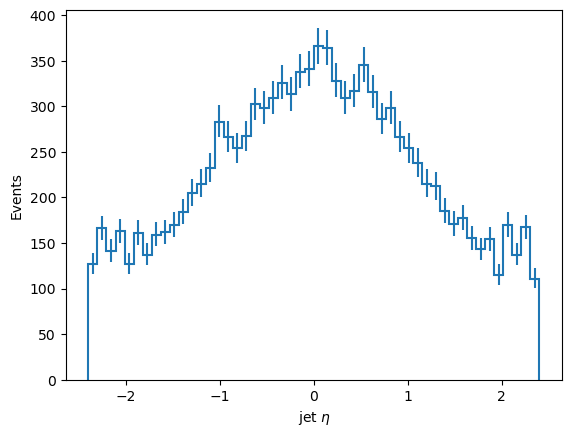

In [28]:
# project into an axis
jet_histogram.project("jet_eta").plot1d()
plt.ylabel("Events");

We could alse visualize 2D histograms using the `plot2d()` method:

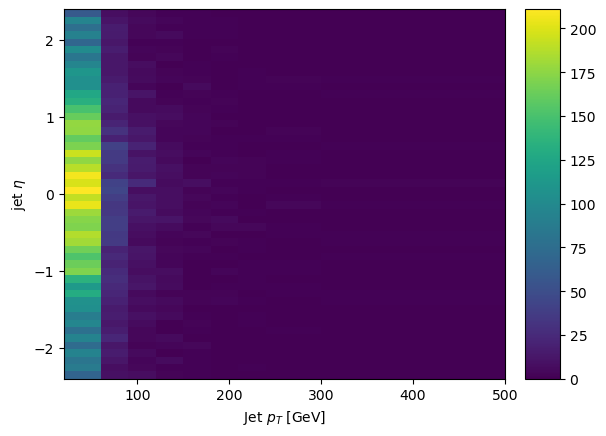

In [29]:
# select all entries for the first two axis and plot 2D histogram
jet_histogram[:, :, sum].plot2d();

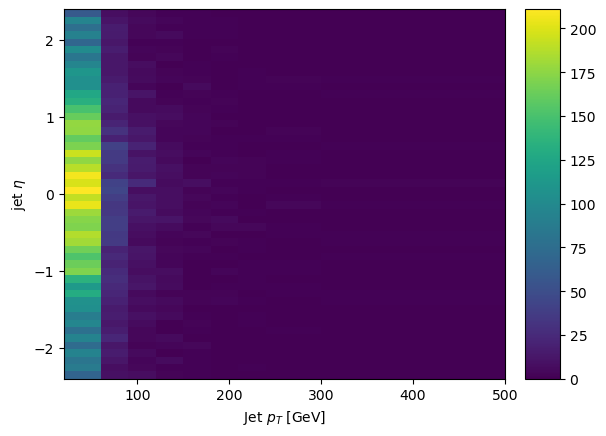

In [30]:
# project on two axisand plot 2D histogram
jet_histogram.project("jet_pt", "jet_eta").plot2d();

see more about histogram manipulation and transformations [here](https://github.com/CoffeaTeam/coffea/discussions/705)

**Quiz 1 (particle-level cut):** Select electrons that satisfy the following conditions

* $p_T \geq 30$ GeV
* $|\eta| < 2.5$
* electrons with a loose PF Relative Isolation working point (`pfRelIso03_all` < 0.25)

In [31]:
good_electrons = (
    (events.Electron.pt >= 30)
    & (np.abs(events.Electron.eta) < 2.5)
    & (events.Electron.pfRelIso03_all < 0.25)
)

electrons = events.Electron[good_electrons]

**Quiz 2: (event-level cut)** Select transverse missing energy (MET) for events in which the condition $p_T(j) \geq 30$ GeV is met for at least two jets

hint: use the `ak.sum()` function

In [32]:
# we want jets with a pt of at least 30
jet_pt_min = events.Jet.pt > 30

# We want MET where the above condition is met for at least two jets. 
# The above is a list of Boolean sublists generated from the jet sublists (True if condition met, False if not). 
# If we sum each sublist, we get the amount of jets matching the condition (since True = 1).
met = events.MET[(ak.sum(jet_pt_min, axis=1) >= 2)]

**Quiz 3:** Using the full dataset:

* Select muons that satisfy the following conditions

  * $p_T \geq 35$ GeV
  * $|\eta| < 2.4$
  * muons with a tight cut-based identification working point (`tightId`)
  * muons with a tight PF Relative Isolation working point (pfRelIso04_all $\leq 0.15$)

* Select the leading and subleading muons $\mu_1$ and $\mu_2$ (use the `ak.firsts()` function)
* Compute the invariant mass $m(\mu_1, \mu_2)$ using the following formula: $$m^2(\mu_1, \mu_2) = 2 p_T(\mu_1)p_T(\mu_2)f(\eta, \phi)$$

  where $$f(\eta, \phi) = \cosh[\eta(\mu_1) - \eta(\mu_2)] - \cos[\phi(\mu_1) - \phi(\mu_2)]$$
* Select events such that $60 < m < 120$ (GeV)
* Create and plot an histogram of the invariant mass (hint: use the `ak.fill_none()` if needed)

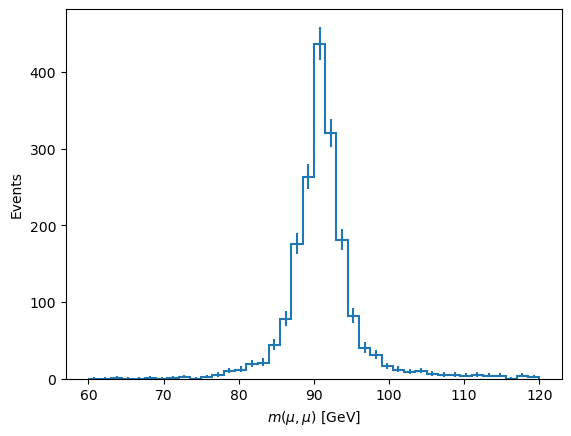

In [33]:
# load events
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema, entry_stop=100_000).events()

# select good muons
good_muons = (
    (events.Muon.pt >= 35)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.tightId)
    & (events.Muon.pfRelIso04_all < 0.15)
)
muons = events.Muon[good_muons]

# select leading and subleading muons
mu1 = ak.firsts(muons)
mu2 = ak.firsts(ak.pad_none(muons, 2)[:, 1:])

# compute invariant mass from the system composed of the leading and subleading muons
dimuon_mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)

# select events in a mass window of 30 GeV around the mass of the Z boson (~91 GeV)
mass_window_cut = (dimuon_mass > 60) & (dimuon_mass < 120)
dimuon_mass = dimuon_mass[mass_window_cut]

# define and fill the dimuon mass histogram
dimuon_mass_axis = hist.axis.Regular(
    bins=40, start=60, stop=120, name="dimuon_mass", label="$m(\mu, \mu)$ [GeV]"
)
dimuon_mass_histogram = hist.Hist(dimuon_mass_axis)
dimuon_mass_histogram.fill(dimuon_mass=ak.fill_none(dimuon_mass, 0)).plot1d()
plt.ylabel("Events");